This notebook aims at giving an automated framework to test a rs-fMRI-tagret TMS pipeline for only one patient

Input :

- Image : Nifti_Image of the fMRI brain time series
- frontal_mask_img : mask of the dlPFC
- TMS_result : float
Output :

- BIC, AMI, DISTANCE, VAR_DIST : average accuracy and reproducibility scores on the different images.
- target : target recommended by the pipeline.


!! The signs of correlations are reversed, so for anticorrelations, wer look at the red areas!

# 0. Initialization

In [1]:
import nibabel as nib
import numpy as np
import os
import nilearn
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import time
from nibabel import imagestats
from nilearn import datasets, plotting, surface, image, masking
from nilearn.maskers import NiftiSpheresMasker, NiftiMasker
from nilearn.surface import vol_to_surf
from nilearn.datasets import get_data_dirs
from nilearn.plotting import plot_epi
from plotly import graph_objects as go
from nilearn import plotting, surface, datasets
from nilearn import surface
from nilearn import plotting
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from nilearn.image import mean_img, math_img
from nilearn.plotting import plot_prob_atlas
from matplotlib import patches, ticker
from nilearn import datasets, plotting
from nilearn.image import get_data, index_img, mean_img
from nilearn.regions import Parcellations
from nilearn.plotting import view_img
from scipy.sparse import coo_matrix
import math
from nilearn.regions import RegionExtractor

# I. Import the images (NIFTI format)

In [2]:
# to replace with the right NIFTI images
Images = []
image_Ids = [1,3,6,7,9,11,12,13,14,15,16,19,20,22,25]
image_Str = ['01RV','03DC','06LL','07CM','09LN','11DF','12CF','13GE','14RY','15RJ','16CT','19OD','20CR','22VC','25BA']
for i in range(len(image_Ids)):
    Images += [nib.load('Data/RealData/STC_NoGSR_NoSmoothing/raw'+str(image_Ids[i])+'_bold_clean-32-parameters.nii')]

frontal_mask_img = nib.load('Data/dlPFC_Mask/Julich/MaskJulich_V7.nii') 

TMS_results = [-3,-6,-14,1,-30,-25,-14,0,0,-36,-16,-25,-17,-16,-9]

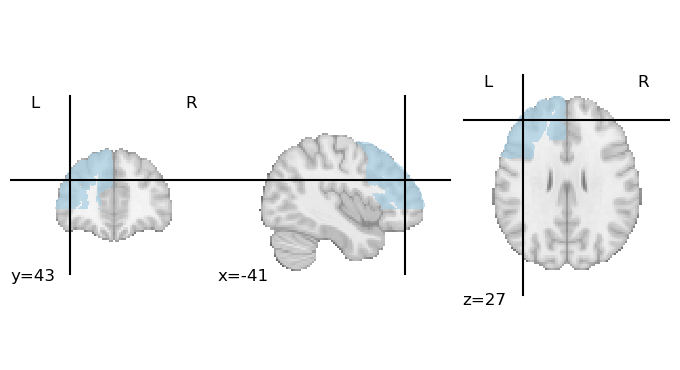

In [3]:
plotting.plot_roi(
frontal_mask_img,
cut_coords=(-41, 43, 27),
colorbar=False,
cmap="Paired",)

In [4]:
# Import real target
Real_Target = np.array([-41, 43, 27])

# II. Give your pipeline

In [5]:
import ClusterFunctions
from sklearn.decomposition import PCA

In [6]:
def Pipeline(input_FCmap,input_brain_time_series) :
    """
    Apply pipeline from the FC_map to the recommended target.


    Output:
        numpy array: Array with noise added to each time series.
    """
    # CONSENSUS
    best_consensus_target,consensus_cluster = ClusterFunctions.consensus_main(input_FCmap,niimg,frontal_mask_img)
    #best_consensus_target,consensus_cluster = ClusterFunctions.extract(input_FCmap,niimg,frontal_mask_img,0,verbose = False)
            #ClusterFunctions.plot_real_to_cash(consensus_cluster_img,niimg,best_consensus_target,'Greys',False,Title='Consensus target')

        # Apply PCA to reduce dimensionality
    flattened_arr = consensus_cluster.reshape(-1, consensus_cluster.shape[-1])  # Reshape to (100*200, 100)
    n_components = 1  # Number of components after dimensionality reduction
    pca = PCA(n_components=n_components)
    reduced_arr = pca.fit_transform(flattened_arr)

    # BAGGING STRATEGY
        #bagging_best_target = ClusterFunctions.bagging_non_overlap(input_brain_time_series, niimg,frontal_mask_img,brain_masker,SgACC_time_series,n=8,weight_mean=10)
    bagging_best_target, intersection_array = ClusterFunctions.bagging_overlap(input_brain_time_series, niimg,frontal_mask_img,brain_masker,SgACC_time_series,perc=0.5,n=5)
    final_target = np.mean([best_consensus_target,bagging_best_target],0)

    return np.ceil(final_target).astype(int),reduced_arr,intersection_array

# III. Get BIC AMI, DISTANCE & DIST. VAR for all images

In [ ]:
niimg = datasets.load_mni152_template()
bin_niimg = nilearn.image.binarize_img(niimg)
SgACC_coords = [(-4,21,-8)]
brain_masker = NiftiMasker(mask_img=frontal_mask_img, smoothing_fwhm=6, detrend=True, 
            standardize='zscore_sample', low_pass=0.1, high_pass=0.01, t_r=2, verbose=0)

TARGETS = []
SCORES = []

# INITIALIZATION
for i in range(len(Images)):
    print(i)
    seed_masker = NiftiSpheresMasker(SgACC_coords, radius=8, detrend=True, standardize=True, 
                                     low_pass=0.1, high_pass=0.01, t_r=2, verbose=0,target_shape = Images[i].get_fdata().shape[:3], target_affine = Images[i].affine,)
    SgACC_time_series= seed_masker.fit_transform(Images[i])
    mean_brain_time_series = brain_masker.fit_transform(Images[i])

        # Median Correlations
    correlation_matrix = SgACC_time_series * mean_brain_time_series
    flatten_mean_fc_map = -np.median(correlation_matrix, axis=0).reshape(-1, 1)

        # Mean Correlations
    #flatten_mean_fc_map = -(np.dot(mean_brain_time_series.T, SgACC_time_series) / SgACC_time_series.shape[0]) # ! renversée

    mean_fc_map = brain_masker.inverse_transform(flatten_mean_fc_map.T)
    # APPLY PIPELINE ON DATA
    expected_target,_,final_cluster = Pipeline(mean_fc_map,mean_brain_time_series)
    # CREATE NOISY MAPS BASED ON DATA
    TARGETS += [expected_target]
    
    # SCORING
    FC_mean = -mean_fc_map.get_fdata() # dans l'array, les valeurs sont réelles (non inversées)
    consensus_cluster_reshape = final_cluster.reshape((193, 229, 193, 1))
    E_field = nib.load('Data/SIMNIBS/sub-100'+image_Str[i]+'_TMS_1-0001_MagStim_D70_scalar_MNI_magnE.nii')
    data = E_field.get_fdata()
    data[data < 0.9*np.max(data)] = 0
    new_E_field = nilearn.image.new_img_like(E_field, data, affine=E_field.affine, copy_header=False)
    new_E_field = nilearn.image.resample_img(new_E_field, target_affine=mean_fc_map.affine, target_shape=mean_fc_map.get_fdata().shape[:3], interpolation='continuous', copy=True, order='F', clip=True, fill_value=0, force_resample=False)
    E_field_AND_cluster = np.logical_and(new_E_field.get_fdata() != 0, consensus_cluster_reshape != 0).astype(int)
    E_field_AND_cluster_AND_FC_mean = np.logical_and(E_field_AND_cluster != 0, FC_mean != 0).astype(int)
    #score =  np.count_nonzero(FC_mean < 0) / np.count_nonzero(FC_mean)
    score =  np.mean(FC_mean[FC_mean < 0])
    SCORES += [score] #[np.round(score*100,2)]



/opt/anaconda3/lib/python3.9/site-packages/nilearn/image/image.py:1066: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


0


/opt/anaconda3/lib/python3.9/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


(193, 229, 193)
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ...

/opt/anaconda3/lib/python3.9/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


(193, 229, 193)
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ...

/opt/anaconda3/lib/python3.9/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


### PLOT NEXT TO CASH

In [ ]:
#print(expected_target)
#ClusterFunctions.plot_real_to_cash(mean_fc_map,niimg,expected_target,'seismic','Patient')

In [ ]:
print(SCORES)

# Predictive score with E-field

In [ ]:
# PLOT PREDICTIVE POWER

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Fit linear regression model
model = LinearRegression()
x_reshaped = np.array(SCORES).reshape(-1, 1)
model.fit(x_reshaped, TMS_results)

# Predict y values using the fitted model
y_pred = model.predict(x_reshaped)

# Calculate R-squared
r_squared = r2_score(TMS_results, y_pred)

# Plot scatter plot of the data points
plt.scatter(SCORES, TMS_results, color='blue', label='Data Points')

# Plot the linear regression line
plt.plot(SCORES, y_pred, color='red', label='Linear Regression')

# Add labels and legend
plt.xlabel('Mean FC')
plt.ylabel('MADRS delta')
plt.title(f'Scatter Plot with Linear Regression (R-squared: {r_squared:.2f}), a = '+str(np.round(model.coef_[0],2)))
plt.legend()

# Show plot
plt.grid(True)
plt.show()